In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from heka_reader import Bundle

import numpy as np
import operator
import math

plt.rcParams['figure.figsize'] = (20, 12)

In [6]:
def get_spike_indices(trace, edge, num_stds):
    """
    Gets indices of spikes in extracellular recordings.
    Adapted from Bartosz Telenczuk: https://github.com/btel/SpikeSort
    """
    thresh = np.std(trace) * num_stds
    
    op1, op2 = operator.lt, operator.gt
    
    edges = ['rising', 'falling']
    
    assert edge in edges
    if edge == 'falling':
        op1, op2, = op2, op1
        thresh = -thresh
    
    i, = np.where(op1(trace[:-1], thresh) & op2(trace[1:], thresh))
    
    return i

In [8]:
def fit_sine_polar(x, y):
    """
    Fits a sine wave with a frequency of 1 to data from a polar plot.
    Adapted from Ed Tate: http://exnumerus.blogspot.com/2010/04/how-to-fit-sine-wave-example-in-python.html
    """
    rows = [[np.sin(t), np.cos(t), 1] for t in x]
    
    a = np.matrix(rows)
    b = np.matrix(y).T
    
    w = np.linalg.lstsq(a, b)[0]
    
    phase = math.atan2(w[1, 0], w[0, 0])
    amplitude = np.linalg.norm([w[0, 0], w[1, 0]], 2)
    bias = w[2, 0]
    
    return (phase, amplitude, bias)

In [60]:
# ds_cell = r'E:\DS traces\R2P_161103_03.dat'
ds_cell = r'E:\DS traces\R2P_161117_01.dat'

bundle = Bundle(ds_cell)
data = bundle.data

In [102]:
sweeps  = [i for i in range(12)]
indices = [[0, 3, sweep, 2] for sweep in sweeps]
traces  = [data[index] for index in indices]

onsets = [get_spike_indices(trace, 'rising', 15)[-2] for trace in traces]

In [114]:
sweeps  = [i for i in range(12)]
indices = [[0, 4, sweep, 0] for sweep in sweeps]
traces  = [data[index] for index in indices]
traces  = [trace[onset:] for trace, onset in zip(traces, onsets)]

spike_indices = [get_spike_indices(trace, 'falling', 4) for trace in traces]
num_spikes = [len(spike_index) for spike_index in spike_indices]

num_spikes

[32, 133, 76, 65, 153, 25, 166, 6, 191, 8, 165, 5]

116.57580832165648

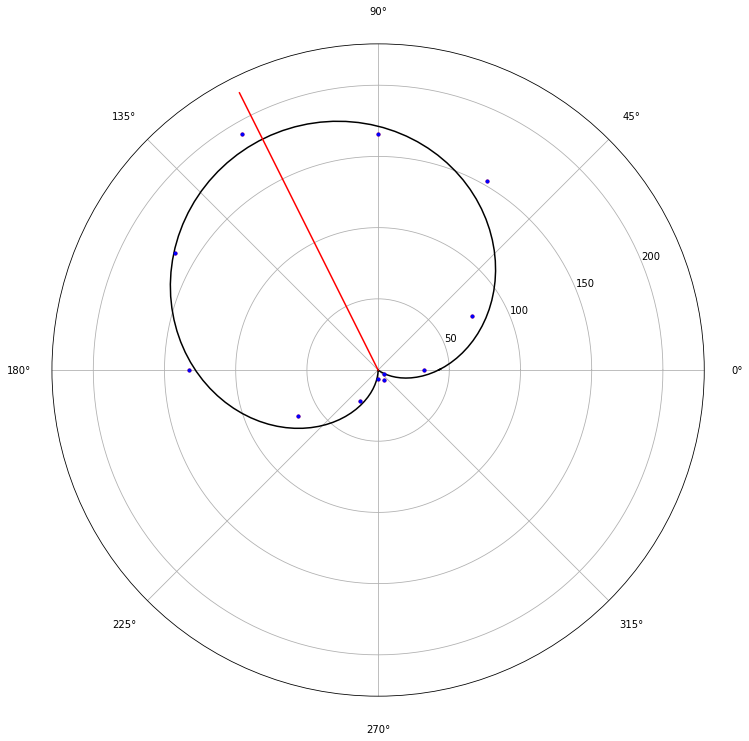

In [116]:
dirs = [0, 180, 30, 210, 60, 240, 90, 270, 120, 300, 150, 330]

directions = np.array(dirs) / 180 * math.pi
assert len(directions) == len(num_spikes)

# REAL NON DS DATA
plt.polar(directions, num_spikes, '.r')

phase, amplitude, bias = fit_sine_polar(directions, num_spikes)

xs = np.arange(0, 2*math.pi+0.05, 0.05)
y_est = amplitude * np.sin(xs + phase) + bias

plt.polar(xs, y_est, '-k')
plt.polar(directions, num_spikes, '.b')

pref_dir = math.pi / 2 - phase
if pref_dir < 0:
    pref_dir += 2 * math.pi
pref_fit = amplitude * math.sin(pref_dir + phase) + bias

plt.polar([pref_dir, 0], [pref_fit*1.2, 0], '-r')
pref_dir / math.pi * 180